In [1]:
import os
import jieba

In [2]:
def cut(string): return ' '.join(jieba.cut(string))

In [3]:
path = 'crawler/'

In [4]:
len(os.listdir(path))

11219

In [5]:
os.listdir(path)[1]

'mod=viewthread&tid=100024&extra=page%3D6'

In [6]:
corpus = [
    cut(open(os.path.join(path, f)).read()) for f in os.listdir(path) if f !='.DS_Store'
]

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/_1/8g6kq5zs3h97jlvhdzj6dldc0000gp/T/jieba.cache
Loading model cost 0.912 seconds.
Prefix dict has been built succesfully.


In [7]:
len(corpus)

11218

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [9]:
vectorizer.fit_transform(corpus)

<11218x48971 sparse matrix of type '<class 'numpy.float64'>'
	with 350112 stored elements in Compressed Sparse Row format>

In [10]:
min(vectorizer.vocabulary_.values())

0

In [11]:
max(vectorizer.vocabulary_.values())

48970

In [12]:
tfidf = vectorizer.fit_transform(corpus)

In [13]:
transposed_tfidf = tfidf.transpose()

In [14]:
transposed_tfidf

<48971x11218 sparse matrix of type '<class 'numpy.float64'>'
	with 350112 stored elements in Compressed Sparse Column format>

In [15]:
import numpy as np

In [16]:
transposed_tfidf_array = transposed_tfidf.toarray()

In [17]:
transposed_tfidf_array.shape

(48971, 11218)

In [18]:
np.where(transposed_tfidf_array[6])

(array([8918]),)

In [19]:
def get_word_id(word):
    return vectorizer.vocabulary_.get(word, None)

In [20]:
get_word_id('上海')

25025

In [21]:
from functools import reduce

In [22]:
from operator import and_

In [29]:
and_({1, 2}, {2, 3})

{2}

In [30]:
import re

In [34]:
def get_candidates_ids(input_string):
    return [get_word_id(c) for c in cut(input_string).split()]

In [35]:
def get_candidates_pat(input_string):
    return '({})'.format('|'.join(cut(input_string).split()))

In [39]:
from scipy.spatial.distance import cosine

In [40]:
def search_enginer(query):
    candidates_ids = get_candidates_ids(query)
    print
    v1 = vectorizer.transform([cut(query)]).toarray()[0]
    
    candidates = [set(np.where(transposed_tfidf_array[_id])[0]) for _id in candidates_ids]
    
    merged_candidates = reduce(and_, candidates)
    
    pat = re.compile(get_candidates_pat(query))
    
    vector_with_id = [(tfidf[i], i) for i in merged_candidates]
    
    sorted_vector_with_ids = sorted(vector_with_id, key=lambda x: cosine(x[0].toarray(), v1))

    sorted_ids = [i for v, i in sorted_vector_with_ids]
    
    for c in merged_candidates:
        output = pat.sub(repl='** \g<1> ** ', string=corpus[c])
        yield ''.join(output.split())

In [47]:
search_enginer('项目 网络')

<generator object search_enginer at 0x1a18996f48>

In [45]:
for i, document in enumerate(search_enginer('项目 网络')):
    if i>10: break
    print(document)

本期主要介绍在高速PCB设计中，高速信号与高速PCB设计存在一些理解误区，水一般的男子从SI基础理论及产品设计工程经验给出一些建议。误区一：GHz速率以上的信号才算高速信号？提到“高速信号”，就需要先明确什么是“高速”，MHz速率级别的信号算高速、还是GHz速率级别的信号算高速？传统的SI理论对于“高速信号”有经典的定义。SI：SignalIntegrity，即信号完整性。SI理论对于PCB互连线路的信号传输行为理解，信号边沿速率几乎完全决定了信号中的最大频率成分，通常当信号边沿时间小于4~6倍的互连传输延时的情况下，信号互连路径会被当做分布参数模型处理，需要考虑SI行为。所谓“高速”，就是指“信号边沿时间小于4~6倍的互连传输延时”，可以看出电路板传输的信号是否为“高速”，不只取决于信号的边沿速率，还取决于电路板线路的路径长度大小，当两者存在一定的比例关系时，该信号应该按照“高速信号”进行处理。误区二：有了仿真软件平台就可以做好高速PCB设计？现在的EDA设计软件平台都集成了高速信号仿真功能，这对于高速PCB设计的规则制定与执行，信号质量仿真与评估都有很大的帮助。但是，在PCB实际设计过程中，有时会出现仿真结果显示信号质量良好，但是实际测试时信号质量很差，不满足信号测试标准，问题出在哪？实际上，仿真与测试是不可分的，拿IBIS模型为例，通常我们称之为“行为级模型”，此类仿真模型也是通过芯片不同工作条件下的V、I测试曲线建立的，这就存在一个问题，仿真时如果不关注选取哪种工作条件下的芯片模型，就会仿真不准，例如：Slow、Typical、Fast。从上面的例子可以看出，“仿真模型库”对于仿真结果至关重要，必须通过实际产品**项目**的仿真测试实际对比、修正后的仿真模型才能算作“准确的仿真模型”。有了好的仿真设计平台不能解决所有问题，还需要“准确的仿真模型”，另外也要考虑到实际产品**项目**的应用场景，仿真的某个信号**网络**，会受到电源噪声、其他信号串扰等因素影响，这同样会造成测试结果与仿真结果的差异。误区三：仿真软件中的PCB走线“传输线模型”是非常准确的？仿真软件中的PCB走线不管是微带线还是带状线，都可以通过仿真工具建立模型，这个模型基于层叠和实际走线的尺寸，通常情况下可以满足精度要求，但是如果说“非常准确”，那还有一些差距，这需要从以下几个方面分析：（1）

## PageRank

In [48]:
import networkx as nx

In [49]:
import random

In [50]:
from string import ascii_letters

In [51]:
def generate_name(): return ''.join([random.choice(ascii_letters.upper()) for _ in range(3)])

In [52]:
generate_name()

'KMG'

In [53]:
social_graph = {
    "Yao": ['Guo', 'Wang', 'Tian', 'Tim'] + [generate_name() for _ in range(4)], 
    "Guo": ['Li'] + [generate_name() for _ in range(5)],
    "Wang": ["Li_2"] + [generate_name() for _ in range(5)], 
    "Li_2": [generate_name() for _ in range(5)], 
    "Li": [generate_name() for _ in range(1)],
}

In [54]:
social_network = nx.graph.Graph(social_graph)

In [55]:
%matplotlib inline

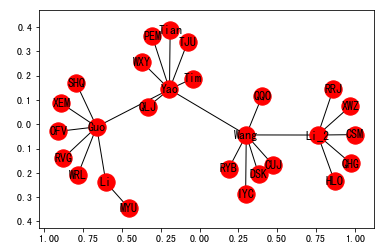

In [56]:
nx.draw_networkx(social_network)

In [57]:
sorted(nx.pagerank(social_network).items(), key=lambda x: x[1], reverse=True)

[('Yao', 0.14018616244938112),
 ('Guo', 0.12625952492883674),
 ('Wang', 0.12354105488402628),
 ('Li_2', 0.11100157862592008),
 ('Li', 0.04009295437632798),
 ('MYU', 0.022595018111845305),
 ('HLO', 0.021279981196290158),
 ('XWZ', 0.021279981196290158),
 ('RRJ', 0.021279981196290158),
 ('QHG', 0.021279981196290158),
 ('CSM', 0.021279981196290158),
 ('XEM', 0.02088716348418851),
 ('SHQ', 0.02088716348418851),
 ('WRL', 0.02088716348418851),
 ('RVG', 0.02088716348418851),
 ('OFV', 0.02088716348418851),
 ('IYC', 0.020557581368083087),
 ('RYB', 0.020557581368083087),
 ('CUJ', 0.020557581368083087),
 ('QQO', 0.020557581368083087),
 ('DSK', 0.020557581368083087),
 ('Tian', 0.020450012730142263),
 ('Tim', 0.020450012730142263),
 ('WXY', 0.020450012730142263),
 ('PEM', 0.020450012730142263),
 ('TJU', 0.020450012730142263),
 ('QLJ', 0.020450012730142263)]

# Summary
1. Build A Search Engine from Zero
2. Inverse Index -> quick retrieval
3. Tfidf -> Similarity Ranking
4. PageRank -> Web Page Importance

distributed python programming https://p16.praetorian.com/blog/multi-core-and-distributed-programming-in-python